In [12]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import time
import pickle
# import json
import importlib
import matplotlib.pyplot as plt

from config import ms_coco_dir

import pylab
pylab.rcParams['figure.figsize'] = (8.0, 5.5)

In [2]:
# use xception descriptors

xc_train = pickle.load(open(ms_coco_dir + '/descriptors/xception/xception-train2017-descriptors.pic', 'rb'))
xc_val = pickle.load(open(ms_coco_dir + '/descriptors/xception/xception-val2017-descriptors.pic', 'rb'))

descriptors_train = xc_train
descriptors_val = xc_val

## Train

Or skip this and just load some model in the inference section

In [43]:
freq_threshold = 0
train_size = 100
num_steps = 50

embeding_size = 200
batch_size = 5
lstm_size = 200
checkpoint_path = 'checkpoints/coco-caption.ckp'
image_descriptor_size = X_images.shape[1]

In [44]:
import utils
importlib.reload(utils)
from utils import load_and_save_captions, load_captions_and_images

# load_and_save_captions(ms_coco_dir, train_size, num_steps, freq_threshold)
X_images, X_captions, Y, X_lens, vocab_size, caption_ids = load_captions_and_images(descriptors_train)

In [45]:
X_images.shape, X_captions.shape, vocab_size

((100, 2048), (100, 50), 16255)

In [11]:
from lstm_captioning_model import RNNCaptioningModel

In [12]:
tf.reset_default_graph()
sess = tf.Session()
model = RNNCaptioningModel(embedding_size=embeding_size, image_descriptor_size=image_descriptor_size, lstm_size=lstm_size, num_steps=num_steps, vocab_size=vocab_size, sess=sess, checkpoint_path=checkpoint_path)
model.build(model_type='train')

In [13]:
sess.run(tf.global_variables_initializer())
# model.saver.restore(sess, checkpoint_path + '-final') # continue training

In [14]:
n_epochs = 10
learning_rate = 0.001
model.train(X_images, X_captions, Y, X_lens, n_epochs, batch_size, learning_rate, evaluate_every=20, save_every=100)

n_epochs = 20
learning_rate = 0.0001
model.train(X_images, X_captions, Y, X_lens, n_epochs, batch_size, learning_rate, evaluate_every=20, save_every=100)

epoch 1
training loss after 20 steps: 3.68624687195 elapsed time: 00h 00m 03s
epoch 2
training loss after 40 steps: 2.50168204308 elapsed time: 00h 00m 06s
epoch 3
training loss after 60 steps: 1.75109219551 elapsed time: 00h 00m 10s
epoch 4
training loss after 80 steps: 1.17539286613 elapsed time: 00h 00m 13s
epoch 5
training loss after 100 steps: 0.761193573475 elapsed time: 00h 00m 16s
saved model to checkpoints/coco-caption.ckp-100
epoch 6
training loss after 120 steps: 0.517965734005 elapsed time: 00h 00m 21s
epoch 7
training loss after 140 steps: 0.380921781063 elapsed time: 00h 00m 24s
epoch 8
training loss after 160 steps: 0.321037262678 elapsed time: 00h 00m 28s
epoch 9
training loss after 180 steps: 0.304425597191 elapsed time: 00h 00m 31s
epoch 10
training loss after 200 steps: 0.24826925993 elapsed time: 00h 00m 34s
saved model to checkpoints/coco-caption.ckp-200
Finished training
Saved final model to checkpoints/coco-caption.ckp-final
Final training loss: 0.248269230127
It

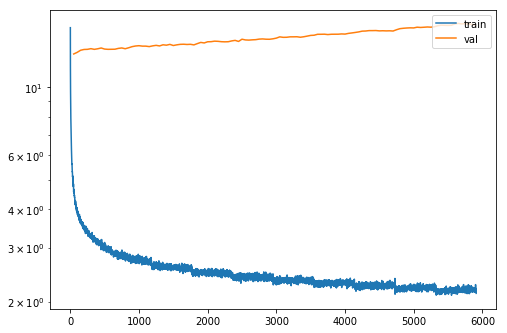

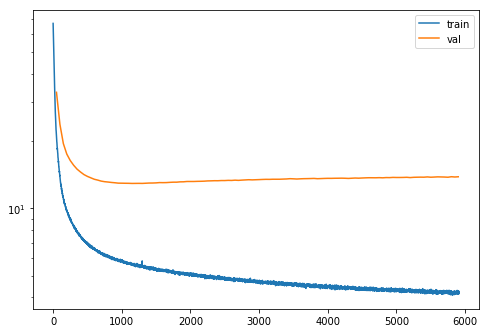

In [22]:
losses, losses_x, losses_val, losses_val_x = np.load('run-1/losses.npy')
plt.figure()
plt.semilogy(losses_x, losses, label='train')
plt.semilogy(losses_val_x, losses_val, label='val')
plt.legend(loc='upper right')

losses, losses_x, losses_val, losses_val_x = np.load('run-2/losses.npy')
plt.figure()
plt.semilogy(losses_x, losses, label='train')
plt.semilogy(losses_val_x, losses_val, label='val')
plt.legend()

In [14]:
losses_x[-1]

5910

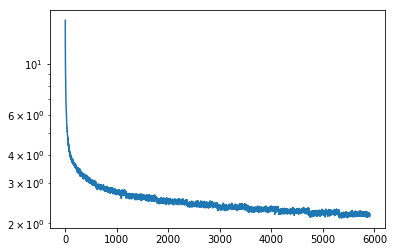

In [4]:
losses = np.load('losses-6000.npy')
plt.semilogy(losses)

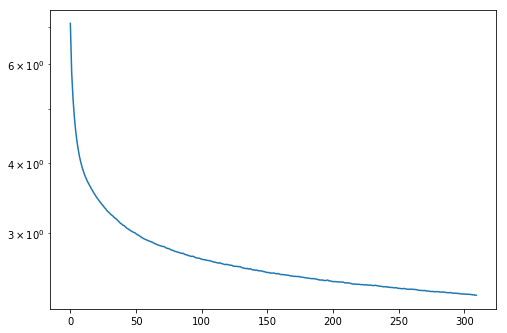

In [11]:
losses1 = np.load('losses-first-1000.npy')
losses2 = np.load('losses-next-2050.npy')
losses = np.concatenate([losses1, losses2])
plt.semilogy(losses)

## Infer

In [3]:
# We need to download the vocab, because the tokenization is done differently there than on my laptop (don't know why).
with open('vocab-train2017.pic', 'rb') as f:
    vocab = pickle.load(f)
id_word = [v[0] for v in vocab]
word_id = {w:i for i,w in enumerate(id_word)}
vocab_size = len(vocab)
vocab_size

16255

In [4]:
# freq_threshold = 0
# train_size = 100
num_steps = 50

embeding_size = 512
batch_size = 1000
lstm_size = 512
checkpoint_path = 'checkpoints-from-server/coco-caption.ckp'
image_descriptor_size = 2048

In [56]:
import lstm_captioning_model
importlib.reload(lstm_captioning_model)
from lstm_captioning_model import RNNCaptioningModel

tf.reset_default_graph()
sess = tf.Session()
model = RNNCaptioningModel(embedding_size=embeding_size, image_descriptor_size=image_descriptor_size, lstm_size=lstm_size, num_steps=num_steps, vocab_size=vocab_size, sess=sess, checkpoint_path=checkpoint_path)
model.build(model_type='infer')
model.saver.restore(sess, checkpoint_path + '-1000')

INFO:tensorflow:Restoring parameters from checkpoints-from-server/coco-caption.ckp-1000


In [9]:
from pycocotools.coco import COCO
coco = COCO(ms_coco_dir + '/annotations/captions_train2017.json')

loading annotations into memory...
Done (t=2.06s)
creating index...
index created!


In [36]:
num_sentences = 20

imgIds = coco.getImgIds()
# imgIds = caption_ids

for i in range(num_sentences):
    idx = np.random.choice(imgIds)
    
    seqs = model.infer(descriptors_train[idx].reshape(1,-1), start_id=word_id['START'], end_id=word_id['END'])
    seq = seqs[0]
    print('PRED:', ' '.join([id_word[w] for w in seq if id_word[w] not in ('START', 'END')]))
    
    annIds = coco.getAnnIds(imgIds=[idx])
    anns = coco.loadAnns(annIds)
    for a in anns:
        print('TRUE:', a['caption'])
    print()

PRED: A small kitchen with a toy microwave and looks on a stove . shelf OF ELEPHANTS toward wall . to shelves printer for us to see . tooth brush and wedge stacks of pictures on the right . hood of
TRUE: A kitchen has dark counters and wood cabinets. 
TRUE: A kitchen with black countertops, chrome appliances, and wooden cabinets.
TRUE: The interior of a kitchen with brown wooden finishes
TRUE: A beautiful and spacious kitchen with stainless steel appliances.
TRUE: A kitchen that has many wooden cabinets and cupboards.

PRED: A cat is sitting on top of a chair in a room . the screen . fireplace . vegetation to be seafood . Football his office at the bar . toward the boy , cellphone in his bed stroller onto the stream .
TRUE:  A man lies in bed resting while a small black and white cat wearing a cone, lies on top of him
TRUE: A cat with a cone on sitting behind a man while he is sleeping.
TRUE: black and white cat with a plastic tunnel watching a man
TRUE: A man lying down and a cat with

PRED: A street appears to be a very good skateboarding . one the trapped and another double-decker with an odd arrow . leather rust into the street is an airport object . pump Flying surrounds a tv inside of a building .
TRUE: A street sign warning traffic of photo enforcement. 
TRUE: A street sigh warning that the traffic light ahead has red light cameras
TRUE: A street  sign on a busy sidewalk corner
TRUE: A street sign indicates that the intersection is enforced by cameras.
TRUE: A view of a street with a sign on the side of the road.

PRED: A couple of cows down a street with an elephant . elephant . its bank . WITH Black-and-white trying to sell many wires . tow with a white building graze water . nearby though the waters in an
TRUE: A baby elephant standing next to a small watering hole.
TRUE: an elephant standing by some water so it can drink some 
TRUE: An elephant is standing next to some water and putting something in its mouth.
TRUE: An elephant at a water hole spraying wate